<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC3_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [1]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-06-11 21:53:31--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat’

ising2_label.dat    100%[===================>]  79.13K   142KB/s    in 0.6s    

2020-06-11 21:53:32 (142 KB/s) - ‘ising2_label.dat’ saved [81025/81025]

--2020-06-11 21:53:34--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M  5.03MB/s    in 3.6s    

2020-06-11 21:53:39 (5.03 MB/s) - ‘ising2_conf.dat’ saved [19060775/190607

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [2]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(tf.__version__)

2.2.0


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [3]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


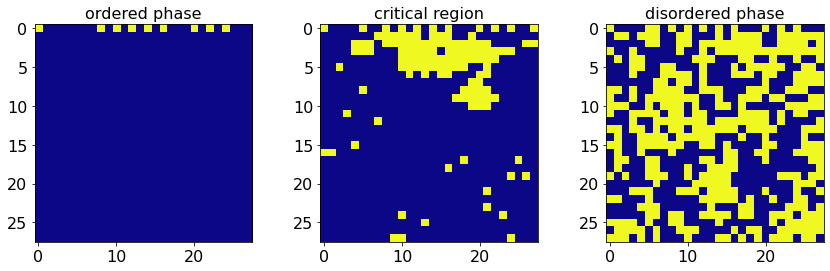

In [4]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [5]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [7]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

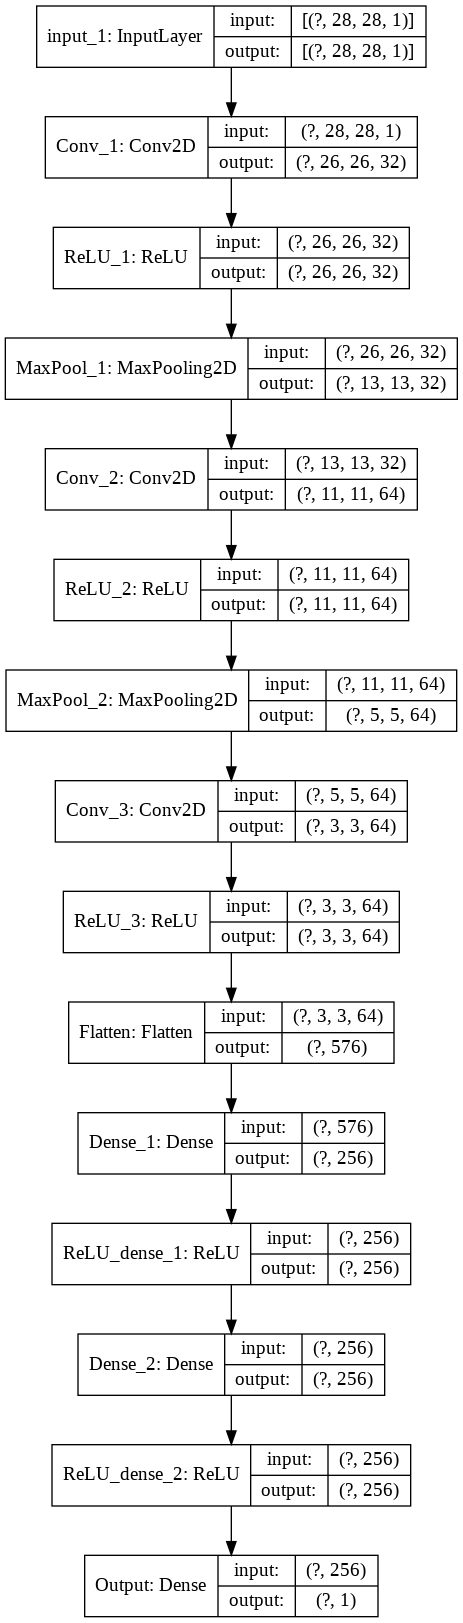

In [8]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
#x = data_augmentation(inputs)
x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

#
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
#tf.keras.layers.Conv2D(
#    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
#    dilation_rate=(1, 1), activation=None, use_bias=True,
#    kernel_initializer='glorot_uniform', bias_initializer='zeros',
#    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#    kernel_constraint=None, bias_constraint=None, **kwargs
#)
#tf.keras.layers.ReLU(
#    max_value=None, negative_slope=0, threshold=0, **kwargs
#)
#tf.keras.layers.MaxPool2D(
#    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
#)
# NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
# ridurre la size dell'immagine dopo lapplicazione del filtro

#
# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Layer denso in Keras
#tf.keras.layers.Dense(
#    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
#    **kwargs
#)
x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [10]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ model_checkpoint ]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 11ms/step - loss: 0.7324 - mean_absolute_error: 0.5953 - val_loss: 0.2572 - val_mean_absolute_error: 0.4321
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2344 - mean_absolute_error: 0.4083 - val_loss: 0.2001 - val_mean_absolute_error: 0.3801
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1714 - mean_absolute_error: 0.3428 - val_loss: 0.1390 - val_mean_absolute_error: 0.3054
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1410 - mean_absolute_error: 0.3016 - val_loss: 0.1842 - val_mean_absolute_error: 0.3410
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1241 - mean_absolute_error: 0.2812 - val_loss: 0.1117 - val_mean_absolute_error: 0.2644
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1171 - mean_absolute_error: 0.2688 - val_loss: 0.1023 - val_mean_absolute_error: 0.2505
Epoch 7/30
50/50 [=========

In [11]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [12]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.1054 - mean_absolute_error: 0.2427

Test loss (MSE): 0.10540328919887543

Test MAE: 0.2427235096693039


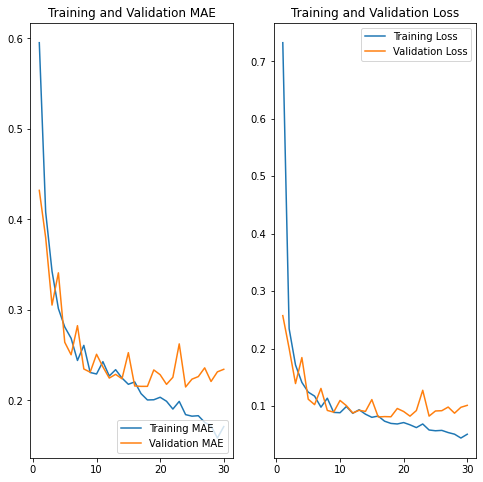

In [13]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.333671 VS 0.101478 Diff= 0.232193
Predicted vs True T: 0.573114 VS 0.190524 Diff= 0.382590
Predicted vs True T: 0.749835 VS 1.489160 Diff= -0.739325
Predicted vs True T: 0.063819 VS 0.428658 Diff= -0.364839
Predicted vs True T: 0.573114 VS 0.878579 Diff= -0.305465
Predicted vs True T: 4.075728 VS 4.380870 Diff= -0.305141
Predicted vs True T: 3.734291 VS 4.237140 Diff= -0.502849
Predicted vs True T: 2.057480 VS 2.140100 Diff= -0.082620
Predicted vs True T: 0.434083 VS 0.557681 Diff= -0.123598
Predicted vs True T: 0.573114 VS 0.742476 Diff= -0.169362
Sample MAE:  [0.32079822]


In [15]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9835


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

**Trovare gi iprparametri ottimali del modello con** *Keras Tuner*

Dato un modello funzionante il passo successivo è quello di ottimizzarne l'archiettura. Questo può essere fatto manualmente (alcuni esempi li abbiamo visti sopra intorducendo il decay del learning rate o introducendo procedure di data_augmentation), oppure in modo sistematico usando tool appositi. Uno di tali tool, semplice e che funziona con keras è appunto [*Keras Tuner*](https://keras-team.github.io/keras-tuner/)


Uso:

1.   si modifica la definizione del modello in modo che acectti un parametro *hp* e in modo tale da modificare gli iperparametri del modello in accordo a diversi metodi di sampling *(hp.Int(), hp.Choice(), ...)*  
2.   si istanzia un oggetto di tipo *tuner* che definisce la strategia di tuning da seguire
3.   si fa partire la ricerca dei parametri e si prina il risultato finale

Esempio pratico:

In [16]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

'''def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.ReLU()(x)
  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  return model'''

"def build_model(hp):\n  inputs = keras.Input(shape=(28,28,1))\n  x = keras.layers.Conv2D(\n      filters=hp.Int('filters', min_value=32, max_value=128, step=32),\n      kernel_size=(3,3))(inputs)\n  x = keras.layers.ReLU()(x)\n  x = keras.layers.MaxPool2D((2,2))(x)\n  x = keras.layers.Flatten()(x)\n  x = keras.layers.Dense(\n      units=hp.Int('units', min_value=32, max_value=512, step=32)\n      )(x)\n  x = keras.layers.ReLU()(x)\n  outputs = keras.layers.Dense(1)(x)\n\n  model = keras.Model(inputs=inputs, outputs=outputs)\n  \n  model.compile(\n        optimizer=keras.optimizers.Adam(\n          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),\n        loss='mse',\n        metrics=['mae'])\n  return model"

In [0]:
#pip install -U keras-tuner

In [18]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
'''import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='ottim_dir')'''

"import kerastuner\n \ntuner = kerastuner.tuners.RandomSearch(\n  build_model,\n  objective='val_loss',\n  max_trials=10,\n  executions_per_trial=2,\n  directory='ottim_dir')"

In [0]:
# start optimisation search
#X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

#tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

In [0]:
# Results
#tuner.results_summary()

In [21]:
# Retrieve the best models
'''models = tuner.get_best_models(num_models=2)

test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)'''

"models = tuner.get_best_models(num_models=2)\n\ntest_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)\nprint('\nTest loss (MSE):', test_loss)\nprint('\nTest MAE:', test_mae)"

**Batch Normalization Layers**

Servono a normalizzare gli output del layer precedente in ogni batch: mantengono la media degli output vicina a zero (in ciascun batch) e la deviazione standard vicina a 1. Questo minimizza effetti di diluzione del gradiente e accelera la convergenza (oltre ad avare un effetto di smoothing sulla funzione di loss stimata con il batch di eventi)


In [0]:
#Esempio uso batch normalisation layers
#tf.keras.layers.BatchNormalization(
#    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
#    beta_initializer='zeros', gamma_initializer='ones',
#    moving_mean_initializer='zeros', moving_variance_initializer='ones',
#    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
#    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99,
#    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
#    **kwargs
#)

#  x = keras.layers.Conv2D(32, kernel_size=(3,3))(x)
#  x = keras.layers.BatchNormalization()(x)
#  x = keras.layers.ReLU(x)

#**Svolgimento dei compiti assegnati**

#Compiti:

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

#**Utilizzo della call-back del learning rate con decay**

Testiamo in primo luogo l'utilizzo di una callback che includa un meccanismo di learning-rate decay: impostiamo cioè un learning rate fisso per Adam per le prime 10 epoche del training, mentre per le successive esso diminuisce esponenzialmente con il numero di epoche. Grafichiamo quindi mse e mae dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

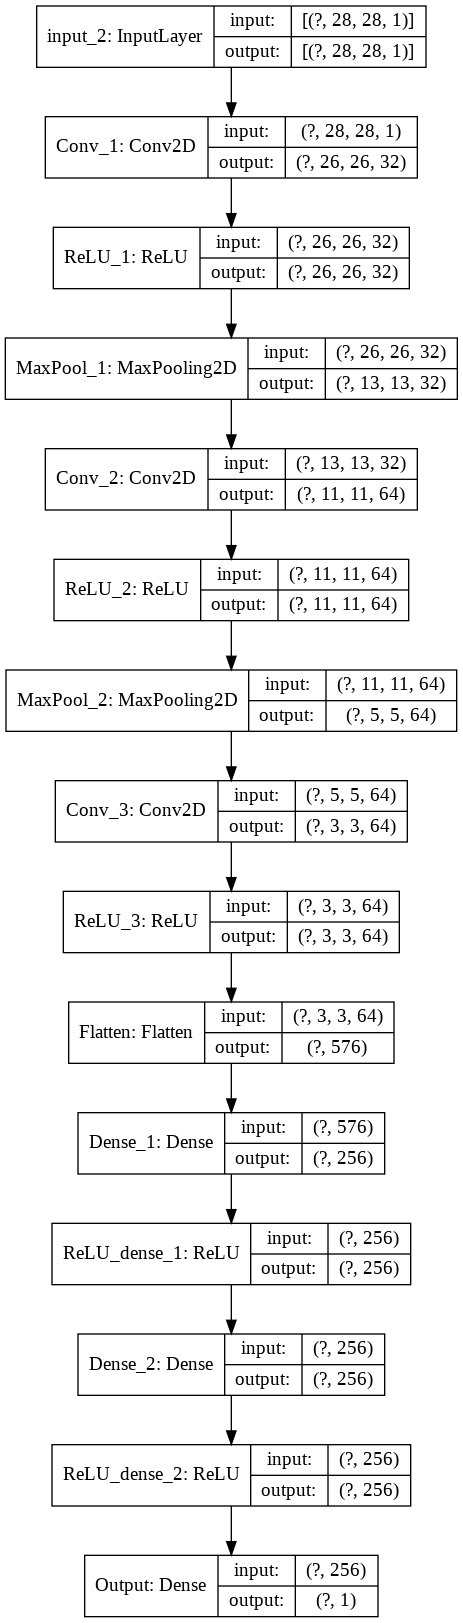

In [23]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae

mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [25]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [model_checkpoint, lr_scheduler]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.8851 - mean_absolute_error: 0.6535 - val_loss: 0.2368 - val_mean_absolute_error: 0.4140 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2349 - mean_absolute_error: 0.4119 - val_loss: 0.2333 - val_mean_absolute_error: 0.4127 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2196 - mean_absolute_error: 0.3989 - val_loss: 0.2125 - val_mean_absolute_error: 0.3939 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2056 - mean_absolute_error: 0.3851 - val_loss: 0.2034 - val_mean_absolute_error: 0.3786 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1985 - mean_absolute_error: 0.3737 - val_loss: 0.1786 - val_mean_absolute_error: 0.3591 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1669 - mean_absolute_error: 0.3411 - val_loss: 0.15

In [26]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [27]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0891 - mean_absolute_error: 0.2297

Test loss (MSE): 0.08906681835651398

Test MAE: 0.2297370433807373


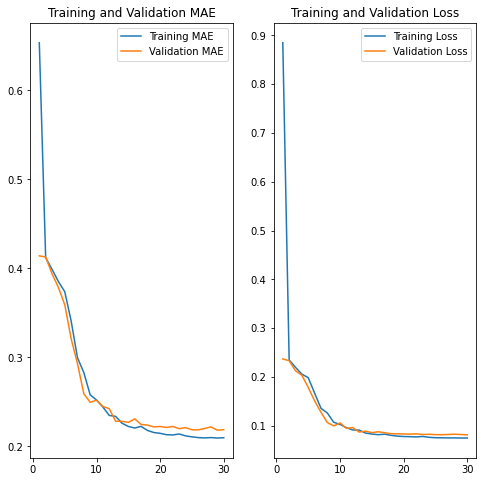

In [28]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Osserviamo che, a partire dalla ventesima epoca, le curve di entrambi i campioni non presentano più dei picchi, come accadeva in precedenza, ma tendono a dei valori costanti, come ci aspettiamo che accada usando una CNN funzionante. Tuttavia, le differenze tra i valori asintotici di mae e mse dei campioni di training e di test sono particolarmente elevate, il che può essere riconducibile a problemi di overfitting.

In [29]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.429016 VS 0.101478 Diff= 0.327538
Predicted vs True T: 0.620149 VS 0.190524 Diff= 0.429625
Predicted vs True T: 0.808513 VS 1.489160 Diff= -0.680647
Predicted vs True T: 0.235928 VS 0.428658 Diff= -0.192730
Predicted vs True T: 0.620149 VS 0.878579 Diff= -0.258430
Predicted vs True T: 4.581339 VS 4.380870 Diff= 0.200469
Predicted vs True T: 3.630808 VS 4.237140 Diff= -0.606332
Predicted vs True T: 1.944960 VS 2.140100 Diff= -0.195140
Predicted vs True T: 0.593393 VS 0.557681 Diff= 0.035712
Predicted vs True T: 0.620149 VS 0.742476 Diff= -0.122327
Sample MAE:  [0.30489492]


In [30]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.978


L'accuracy sul campione di test rimane quasi invariata rispetto al caso in cui non si utilizzi il learning-rate decay.

#**Utilizzo della data-augmentation**

Proviamo ora a modificare la CNN aggiungendo un layer di data augmentation. Dati i risultati incoraggianti ottenuti in precedenza, manteniamo il learning-rate decay. Grafichiamo nuovamente mse e mae dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0 

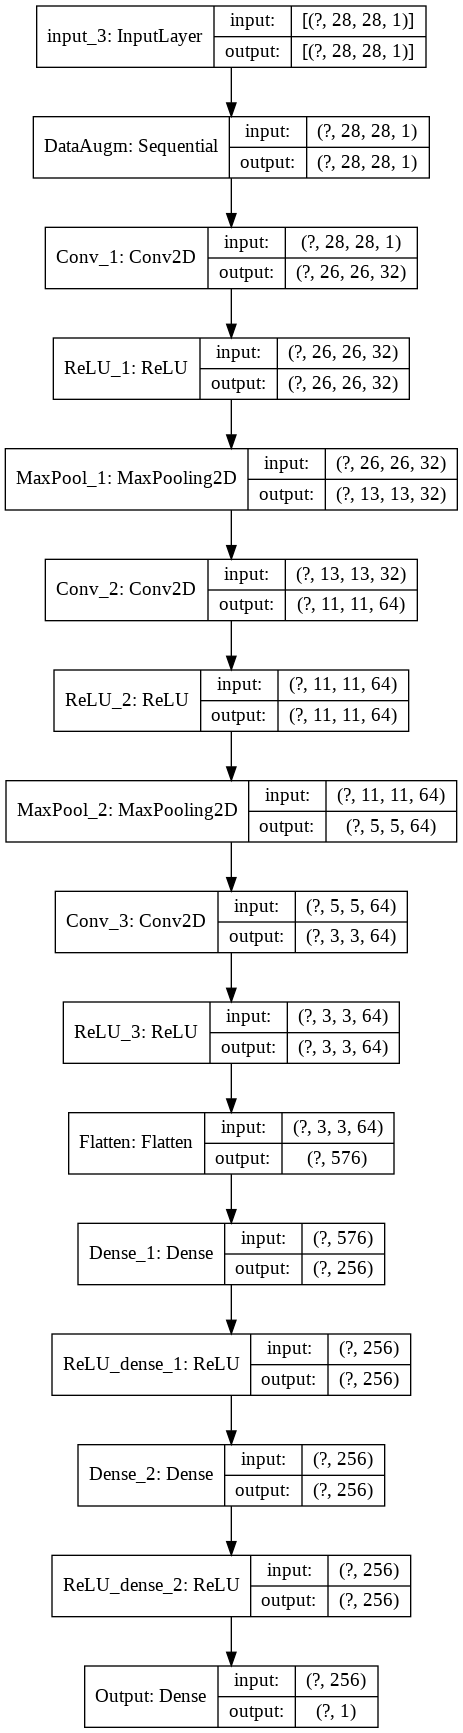

In [31]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)


# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [33]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [model_checkpoint]
callbacks = [lr_scheduler, model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.7164 - mean_absolute_error: 0.6079 - val_loss: 0.2620 - val_mean_absolute_error: 0.4258 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2244 - mean_absolute_error: 0.4034 - val_loss: 0.2066 - val_mean_absolute_error: 0.3833 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1917 - mean_absolute_error: 0.3619 - val_loss: 0.1475 - val_mean_absolute_error: 0.3184 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1475 - mean_absolute_error: 0.3132 - val_loss: 0.1892 - val_mean_absolute_error: 0.3500 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1405 - mean_absolute_error: 0.3026 - val_loss: 0.1214 - val_mean_absolute_error: 0.2778 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1272 - mean_absolute_error: 0.2855 - val_loss: 0.10

In [34]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [35]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0837 - mean_absolute_error: 0.2232

Test loss (MSE): 0.08368189632892609

Test MAE: 0.22322818636894226


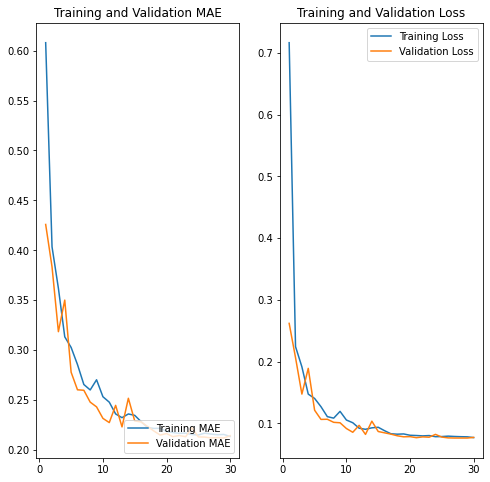

In [36]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Notiamo che ora non solo le curve non presentano più dei picchi, una volta raggiunto il valore asintotico, ma che questo coincide, per i campioni di training e di validazione, sia per il *mse* che per il *mae*: abbiamo quindi risolto i problemi di overfitting della rete.

In [37]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.504237 VS 0.101478 Diff= 0.402759
Predicted vs True T: 0.682827 VS 0.190524 Diff= 0.492303
Predicted vs True T: 1.031540 VS 1.489160 Diff= -0.457620
Predicted vs True T: 0.252161 VS 0.428658 Diff= -0.176497
Predicted vs True T: 0.682827 VS 0.878579 Diff= -0.195752
Predicted vs True T: 4.416225 VS 4.380870 Diff= 0.035356
Predicted vs True T: 3.682710 VS 4.237140 Diff= -0.554430
Predicted vs True T: 1.986496 VS 2.140100 Diff= -0.153604
Predicted vs True T: 0.613241 VS 0.557681 Diff= 0.055560
Predicted vs True T: 0.682827 VS 0.742476 Diff= -0.059649
Sample MAE:  [0.25835305]


In [38]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9825


L'accuracy è ora diminuita, sebbene di poco, rispetto al valore del 98.4$\%$ ottenuto in precedenza. Questo può essere associato alla risoluzione del problema dell'overfitting, che può aver determinato una accuracy più alta di quella effettivamente ottenibile con una rete di questo tipo.

#**Utilizzo di diverse funzioni di attivazione**

Testiamo ora le performance della rete utilizzando diverse funzioni di attivazione. Ci concentreremo, in particolare, sulla tangente iperbolica, LeakyReLU ed ELU. In tutte le prove che effettueremo manterremo l'utilizzo del layer di data augmentation, nonché del learning-rate decay.

**Tangente iperbolica**

Proviamo per prima la tangente iperbolica.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
tanh_1 (Activation)          (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
tanh_2 (Activation)          (None, 11, 11, 64)        0 

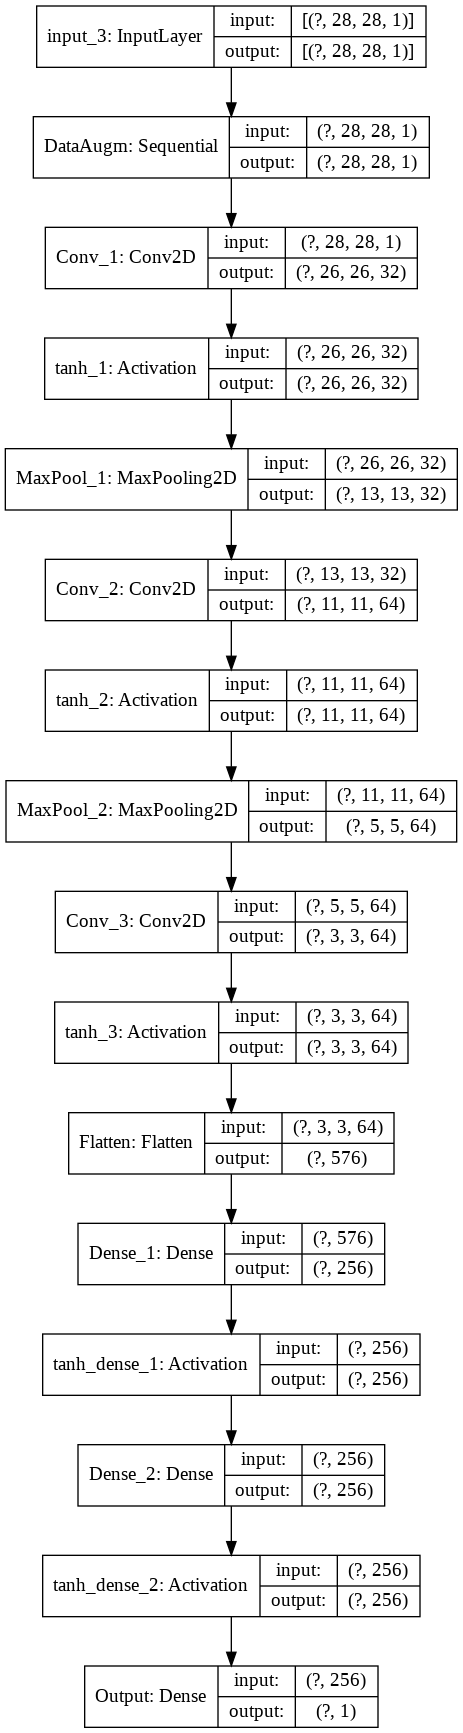

In [198]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.Activation('tanh', name='tanh_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.Activation('tanh', name='tanh_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.Activation('tanh', name='tanh_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.Activation('tanh', name='tanh_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.Activation('tanh', name='tanh_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [200]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.5216 - mean_absolute_error: 0.5391 - val_loss: 0.2389 - val_mean_absolute_error: 0.3991 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2309 - mean_absolute_error: 0.3992 - val_loss: 0.1904 - val_mean_absolute_error: 0.3542 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2094 - mean_absolute_error: 0.3720 - val_loss: 0.1661 - val_mean_absolute_error: 0.3213 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1463 - mean_absolute_error: 0.3071 - val_loss: 0.1576 - val_mean_absolute_error: 0.3184 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1482 - mean_absolute_error: 0.3054 - val_loss: 0.2036 - val_mean_absolute_error: 0.3576 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1213 - mean_absolute_error: 0.2741 - val_loss: 0.12

In [201]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [202]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0919 - mean_absolute_error: 0.2326

Test loss (MSE): 0.09189888834953308

Test MAE: 0.23255100846290588


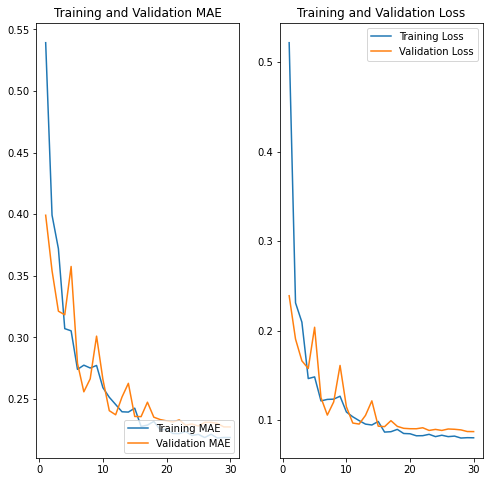

In [203]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

L'andamento riscontrato continua ad essere sufficientemente *smooth*. La rete restituisce anche in questo caso delle curve di *mae* e *mse* valide, che non danno segni di evidente overfitting.

In [204]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.636806 VS 0.101478 Diff= 0.535328
Predicted vs True T: 0.724756 VS 0.190524 Diff= 0.534232
Predicted vs True T: 0.731045 VS 1.489160 Diff= -0.758115
Predicted vs True T: 0.214462 VS 0.428658 Diff= -0.214196
Predicted vs True T: 0.724756 VS 0.878579 Diff= -0.153823
Predicted vs True T: 4.485074 VS 4.380870 Diff= 0.104204
Predicted vs True T: 3.409684 VS 4.237140 Diff= -0.827456
Predicted vs True T: 1.961486 VS 2.140100 Diff= -0.178614
Predicted vs True T: 0.654413 VS 0.557681 Diff= 0.096732
Predicted vs True T: 0.724756 VS 0.742476 Diff= -0.017720
Sample MAE:  [0.342042]


In [205]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.983


L'accuracy sul campione di test rimane perlopiù costante.

**LeakyReLU**

Passiamo allo studio di LeakyReLU.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 11, 11, 64)        0 

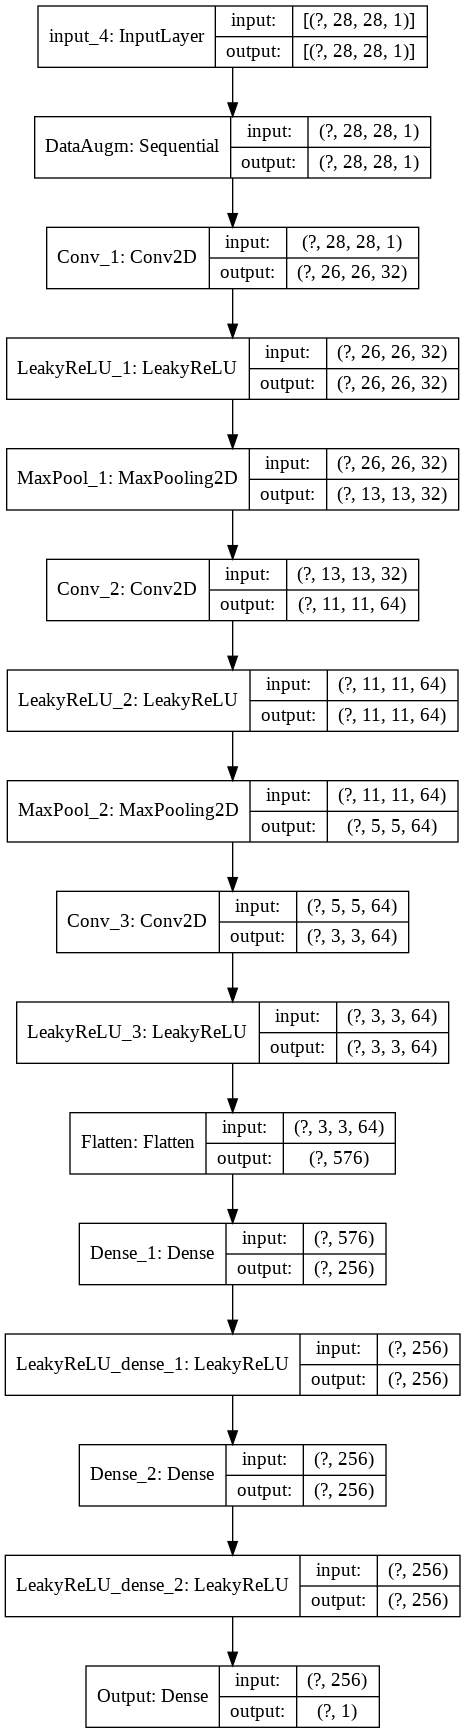

In [206]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [208]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.7878 - mean_absolute_error: 0.6377 - val_loss: 0.2794 - val_mean_absolute_error: 0.4329 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2399 - mean_absolute_error: 0.4111 - val_loss: 0.1981 - val_mean_absolute_error: 0.3800 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1934 - mean_absolute_error: 0.3647 - val_loss: 0.1633 - val_mean_absolute_error: 0.3388 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1632 - mean_absolute_error: 0.3310 - val_loss: 0.1426 - val_mean_absolute_error: 0.2995 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1399 - mean_absolute_error: 0.3020 - val_loss: 0.1173 - val_mean_absolute_error: 0.2777 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1341 - mean_absolute_error: 0.2944 - val_loss: 0.12

In [209]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [210]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0832 - mean_absolute_error: 0.2217

Test loss (MSE): 0.08318730443716049

Test MAE: 0.22166208922863007


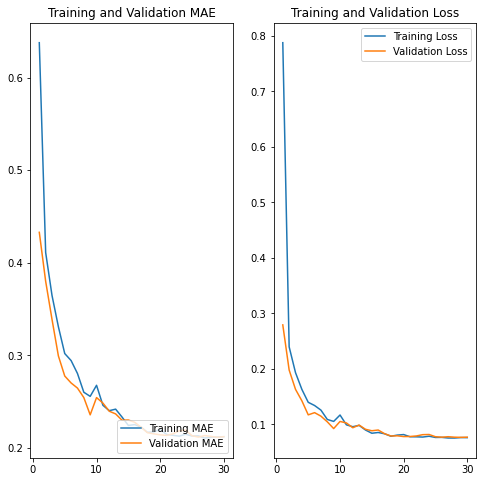

In [211]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* del campione di training e di quello di validazione convergono già prima della ventesima epoca, migliorando i risultati ottenuti fino ad ora. Risultando quasi sovrapponibili, possiamo presumere che non sia presente overfitting.

In [212]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.554472 VS 0.101478 Diff= 0.452994
Predicted vs True T: 0.708420 VS 0.190524 Diff= 0.517896
Predicted vs True T: 0.853982 VS 1.489160 Diff= -0.635178
Predicted vs True T: 0.327090 VS 0.428658 Diff= -0.101568
Predicted vs True T: 0.708420 VS 0.878579 Diff= -0.170159
Predicted vs True T: 4.355050 VS 4.380870 Diff= -0.025820
Predicted vs True T: 3.708231 VS 4.237140 Diff= -0.528909
Predicted vs True T: 2.027644 VS 2.140100 Diff= -0.112456
Predicted vs True T: 0.631463 VS 0.557681 Diff= 0.073782
Predicted vs True T: 0.708420 VS 0.742476 Diff= -0.034056
Sample MAE:  [0.26528186]


In [213]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.986


L'accuracy sul campione di test migliora, giungendo al 98.6$\%$.

**ELU**

Infine, implementiamo ELU.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ELU_1 (ELU)                  (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ELU_2 (ELU)                  (None, 11, 11, 64)        0 

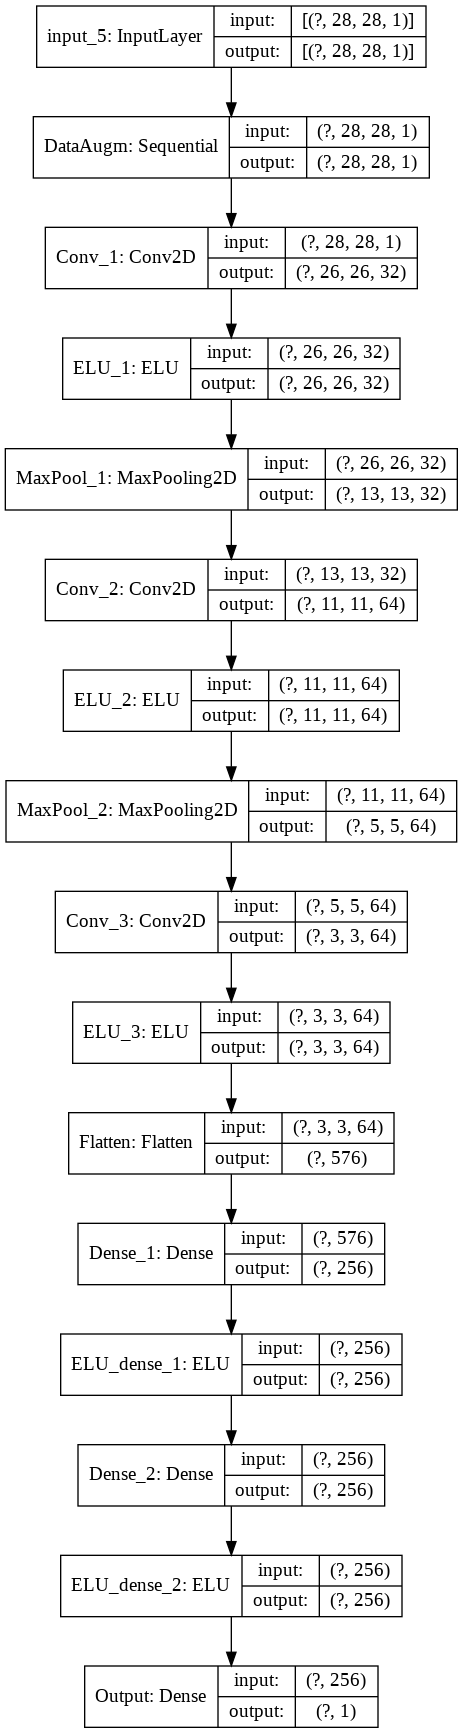

In [214]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ELU(name='ELU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ELU(name='ELU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ELU(name='ELU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ELU(name='ELU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ELU(name='ELU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [216]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.5799 - mean_absolute_error: 0.5451 - val_loss: 0.2373 - val_mean_absolute_error: 0.4123 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2022 - mean_absolute_error: 0.3734 - val_loss: 0.2006 - val_mean_absolute_error: 0.3583 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1694 - mean_absolute_error: 0.3345 - val_loss: 0.1518 - val_mean_absolute_error: 0.3263 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 1s 11ms/step - loss: 0.1447 - mean_absolute_error: 0.3053 - val_loss: 0.1299 - val_mean_absolute_error: 0.2817 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1334 - mean_absolute_error: 0.2886 - val_loss: 0.1187 - val_mean_absolute_error: 0.2766 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1257 - mean_absolute_error: 0.2818 - val_loss: 0.1

In [217]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [218]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0908 - mean_absolute_error: 0.2333

Test loss (MSE): 0.09079378098249435

Test MAE: 0.23332510888576508


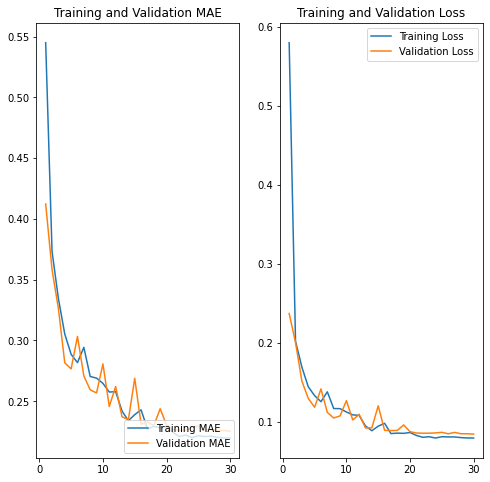

In [219]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* convergono anche utilizzando ELU come funzione di attivazione, sebbene tale convergenza sia ora più tardiva e gli andamenti non siano perfettamente sovrapponibili (come abbiamo osservato, invece, con LeakyReLU).

In [220]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.649844 VS 0.101478 Diff= 0.548366
Predicted vs True T: 0.700445 VS 0.190524 Diff= 0.509921
Predicted vs True T: 0.772096 VS 1.489160 Diff= -0.717064
Predicted vs True T: 0.279839 VS 0.428658 Diff= -0.148819
Predicted vs True T: 0.700445 VS 0.878579 Diff= -0.178134
Predicted vs True T: 4.227589 VS 4.380870 Diff= -0.153281
Predicted vs True T: 3.691277 VS 4.237140 Diff= -0.545863
Predicted vs True T: 1.995347 VS 2.140100 Diff= -0.144753
Predicted vs True T: 0.686365 VS 0.557681 Diff= 0.128684
Predicted vs True T: 0.700445 VS 0.742476 Diff= -0.042031
Sample MAE:  [0.3116915]


In [221]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.979


L'accuracy sul campione di test peggiora leggermente, risultando ora 97.9$\%$.

#**Utilizzo di Keras Tuner**

Per ottimizzare la rete creata, utilizziamo la tecnica del tuning degli iperparametri, mediante *keras tuner*. Modifichiamo la rete in modo che accetti un parametro (ovvero un iperparametro) che possa essere ottimizzato dal *tuner*. Si fa dunque iterare l'algoritmo più volte, in modo da ottenere la migliore stima del parametro da utilizzare. <br />
Anche in questo caso manteniamo il layer di data augmentation ed il learning-rate decay. Sostituiamo però la funzione di attivazione ReLU con LeakyReLU, in quanto abbiamo ottenuto risultati migliori con essa.

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))

  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')

  x = data_augmentation(inputs)

  #first convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=16, max_value=128, step=16),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  #second convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  #third convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  x = keras.layers.Flatten()(x)
  
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)
  
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)
  
  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  return model

In [275]:
pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [276]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='my_dir')

INFO:tensorflow:Reloading Oracle from existing project my_dir/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/untitled_project/tuner0.json


In [277]:
# start optimisation search
X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

INFO:tensorflow:Oracle triggered exit


In [278]:
# Results
tuner.results_summary()

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=2)

In [280]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = models[0].fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 18.8904 - mae: 2.1030 - val_loss: 0.2703 - val_mae: 0.4093 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 18ms/step - loss: 0.1571 - mae: 0.3221 - val_loss: 0.1318 - val_mae: 0.2982 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 1s 17ms/step - loss: 0.1261 - mae: 0.2878 - val_loss: 0.1215 - val_mae: 0.2820 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 1s 20ms/step - loss: 0.1173 - mae: 0.2747 - val_loss: 0.1152 - val_mae: 0.2729 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 1s 18ms/step - loss: 0.1118 - mae: 0.2671 - val_loss: 0.1103 - val_mae: 0.2668 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 1s 17ms/step - loss: 0.1068 - mae: 0.2602 - val_loss: 0.1062 - val_mae: 0.2632 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1029 - mae: 0.2553 - val_loss: 0.1041 - val_mae: 0.2594 - lr: 

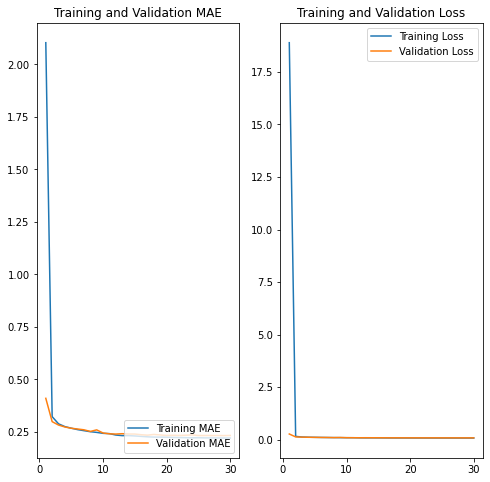

In [281]:
#plot della loss e della MAE durante il training

mae = history.history['mae']
val_mae = history.history['val_mae']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* convergono molto presto e sono perfettamente sovrapponibili. Non riteniamo pertanto di essere in presenza di overfitting.

In [282]:
test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0886 - mae: 0.2345

Test loss (MSE): 0.08860884606838226

Test MAE: 0.23447594046592712


In [283]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = models[0].predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)

Accuracy is:  0.976


L'accuracy sul campione di test scende ulteriormente, arrivando al 97.6$\%$.

#**Batch-Normalization layer**

Testiamo ora la stessa rete di partenza, ma con l'aggiunta di due *batch-normalization layers* nei primi due blocchi convoluzionali. Grafichiamo il *mse* e il *mae* dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
ReLu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        25

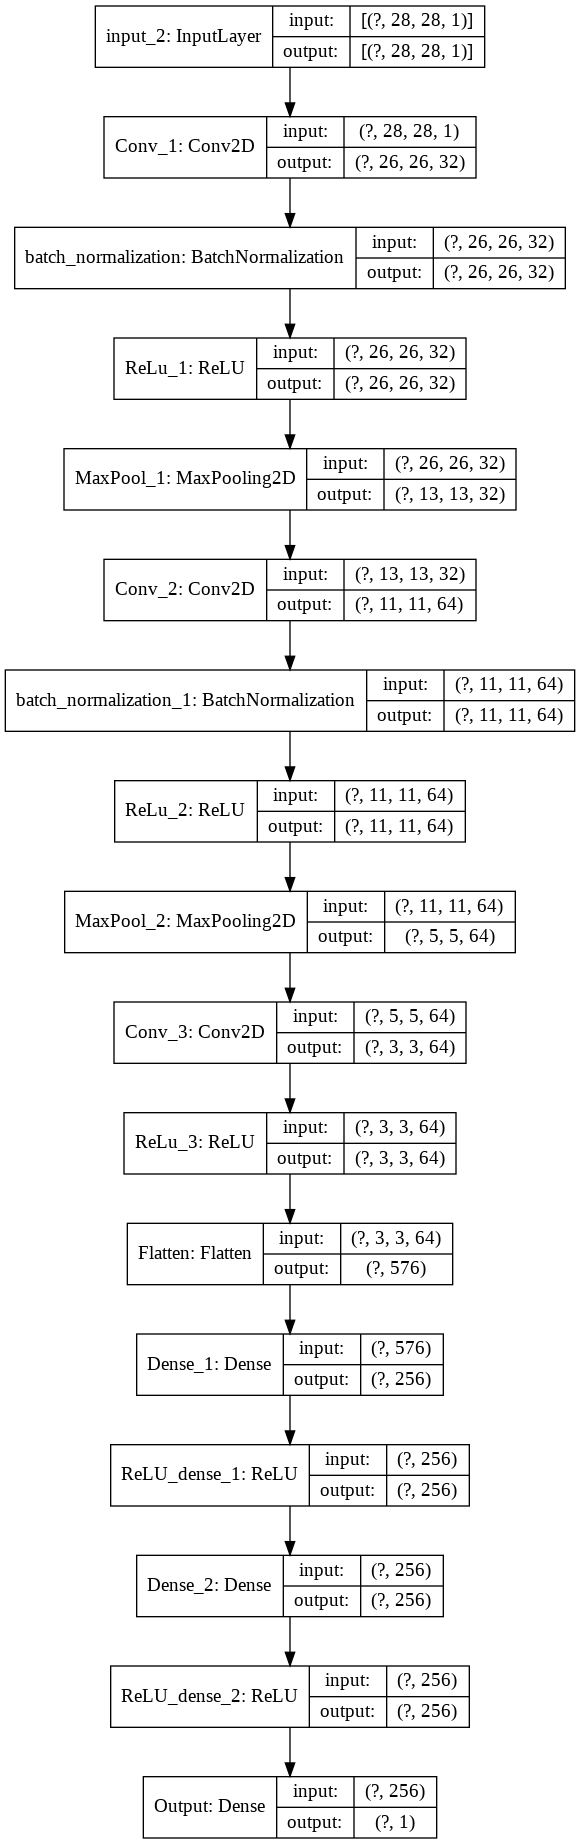

In [284]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

x = inputs


# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLu_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLu_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLu_3')(x)


# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [286]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [model_checkpoint]
callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.4944 - mean_absolute_error: 0.5026 - val_loss: 5.9287 - val_mean_absolute_error: 2.0590
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1862 - mean_absolute_error: 0.3465 - val_loss: 6.0704 - val_mean_absolute_error: 2.0697
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1758 - mean_absolute_error: 0.3289 - val_loss: 5.3917 - val_mean_absolute_error: 1.9300
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1365 - mean_absolute_error: 0.2927 - val_loss: 4.6053 - val_mean_absolute_error: 1.7702
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1437 - mean_absolute_error: 0.2966 - val_loss: 3.9376 - val_mean_absolute_error: 1.6244
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1221 - mean_absolute_error: 0.2709 - val_loss: 2.5070 - val_mean_absolute_error: 1.2893
Epoch 7/30
50/50 [==========

In [287]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [288]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.1219 - mean_absolute_error: 0.2851

Test loss (MSE): 0.12185554951429367

Test MAE: 0.2850758135318756


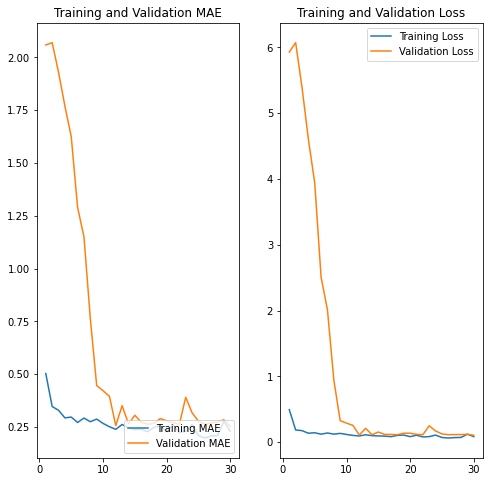

In [289]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

La convergneza delle curve è più rapida di quanto osservato in precedenza. Anche in questo caso non si riscontrano problemi di overfitting, ma i valori assunti dalle curve nella regione di convergenza sembrano variare di più rispetto al caso in cui si è implementata la *data augmentation*.

In [290]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.384962 VS 0.101478 Diff= 0.283484
Predicted vs True T: 0.607199 VS 0.190524 Diff= 0.416675
Predicted vs True T: 0.544407 VS 1.489160 Diff= -0.944753
Predicted vs True T: 0.195478 VS 0.428658 Diff= -0.233180
Predicted vs True T: 0.607199 VS 0.878579 Diff= -0.271380
Predicted vs True T: 4.461060 VS 4.380870 Diff= 0.080190
Predicted vs True T: 3.541873 VS 4.237140 Diff= -0.695268
Predicted vs True T: 1.636821 VS 2.140100 Diff= -0.503279
Predicted vs True T: 0.428730 VS 0.557681 Diff= -0.128951
Predicted vs True T: 0.607199 VS 0.742476 Diff= -0.135277
Sample MAE:  [0.36924362]


In [291]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.978


Anche in questo caso l'accuracy è calata rispetto al valore di riferimento del caso senza *data augmentation* e *batch-normalization layer*. La non perfetta convergenza delle curve di *mse* e *mae* può essere annoverata tra le possibili cause di questo calo.